In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from lmfit import Parameters,minimize, fit_report

Questions
- why do rabi oscillation frequencies differ from theory when coupling isn't the same for both qubits?
- why does everything go crazy when the qubits start in different states
- what is iswap gate
- how to calc fidelty, what is concurrence?

In [99]:
#
# System Constants
#

# aha! this example notebook couples two cubits to one cavity but it uses a gate? 
# https://nbviewer.ipython.org/github/jrjohansson/qutip-lectures/blob/master/Lecture-2A-Cavity-Qubit-Gates.ipynb

# to try changing wc
# https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/brmesolve.ipynb

# constants sources: 
# https://www.nature.com/articles/nature06184 - the useful article
# https://aip.scitation.org/doi/10.1063/1.5089729 - has useful information but for 4 qubits coupled to individual cavities
GHz = 10**9 #Hz
wq1 = 6.617  * GHz * 2* np.pi # 6.617 * GHz * 2* np.pi # wq = sqrt(8EjEc)
wq2 = 6.529 * GHz * 2* np.pi # 2.88 * GHz * 2* np.pi # 6.529 * GHz * 2* np.pi
wc = 5.19 * GHz * 2* np.pi # 5.19 * GHz * 2 * np.pi, 3 works
g1 = 0.105 * GHz * 2 * np.pi # 0.105 * GHz * 2 * np.pi
g2 = 0.105 * GHz * 2 * np.pi # g1
N = 20 # number of qubit fock states considered
use_rwa = False 
n_th_a = 0.0
n1 = 1 # number photons in qubit 1 
n2 = 0 # number photons in qubit 2
# times to evolve over
tlist = np.linspace(0, 18/GHz,10000)

# create drift factor for cavity frequency
if (wc-wq1) != 0 and (wc-wq2) != 0:
    dwc = g1**2/(wc-wq1)**2 + g2**2/(wc-wq2)**2
else:
    dwc = 0
    


In [100]:
#
# Operators, Hamiltonion
#

def wc_dep(t,args):
    return wc + t*dwc

# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
nc = a.dag()*a

# qubit 1 operators
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
nq1 = sm1.dag() * sm1

# qubit 2 operators 
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
nq2 = sm2.dag() * sm2

# small hamiltionians for each system
Hc = nc
Hq1 = -0.5 * sz1 * wq1
Hq2 = -0.5 * sz2 * wq2
if use_rwa:
    Hc1 = g1 * (a.dag()*sm1 + a*sm1.dag())
    Hc2 = g2 * (a.dag()*sm2 + a*sm2.dag())
else:
    Hc1 = g1 * (a.dag() + a)*(sm1 + sm1.dag())
    Hc2 = g2 * (a.dag() + a)*(sm2 + sm2.dag())
# https://journals.aps.org/prapplied/pdf/10.1103/PhysRevApplied.12.054023
z = GHz*2*np.pi # not sure how to use equation from paper to calclulate
H12 = z*sm1.dag()*sm1*sm2.dag()*sm2

#Hamiltonian: Jaynes-Cumming - maybe a different one based on the nature article
# H = wc * Hc + wq1 * Hq1 + wq2 * Hq2 + Hc1 + Hc2
H = [[Hc, wc_dep], Hq1, Hq2, Hc1, Hc2, H12]

In [101]:
#
# Calculate expected Rabi Oscillations for System
#

## https://www.nature.com/articles/s41598-018-35751-3 
## https://iopscience.iop.org/article/10.1088/2399-6528/aadafc
## https://iopscience.iop.org/article/10.1088/1751-8113/46/33/335301/pdf?casa_token=HrohioirAlUAAAAA:G4ZDAnpHl7a3eapu7MBpEGyPgKGOp56XtJpIBNuwZkZnE3MKvOxEWDjzLNAPCy-k0c3q0ff7NQ
## https://www.nature.com/articles/nphys1731
## https://www.nature.com/articles/s41598-019-40899-7 had a thing didn't know what delta was
## https://www.sciencedirect.com/science/article/pii/S1631070516300585 
## https://edoc.ub.uni-muenchen.de/10291/1/Helmer_Ferdinand.pdf end of chapter 1 super helpful, ~pg 47 of doc
## https://physics.stackexchange.com/questions/495374/detuning-in-rabi-oscillations 
## https://www.fulviofrisone.com/attachments/article/404/Fox%20M.%20Quantum%20optics..%20an%20introduction%20(Oxford,%202006)(ISBN%200198566735)(397s)_PQ
## https://journals.aps.org/pra/pdf/10.1103/PhysRevA.86.013836?casa_token=cZMwBqBhZAQAAAAA%3ANVA_jTRJxyxNazahy4Y7i1LsM2bUaKpvffWiWc03lZ1Zg5xCNLBOHAr-pmzQ3Fpf17wmHqBxWbUTMw 
## https://arxiv.org/pdf/1810.00652.pdf, equations used below
m = 2 # 2 qubits
if g1 == g2: #and (abs(wq1-wc) == abs(wq2-wc)):
    r1 = sqrt(m*4*(g1**2)*(n1 + 1) + (wq1-wc)**2)/GHz
    r2 = sqrt(m*4*(g2**2)*(n2 + 1) + (wq2-wc)**2)/GHz
elif g1 != g2 and (wq1 == wc == wq2):
    r1 = 2*sqrt(g1**2 + g2**2)/GHz
    r2 = r1
else:
    print("Rabi frequency prediction is inaccurate")
    r1 = 0
    r2 = 0
print(f"qubit 1 rabi frequency {r1} GHz, qubit 2 rabi frequency {r2} GHz")


qubit 1 rabi frequency 9.346391790807413 GHz, qubit 2 rabi frequency 8.617637750702123 GHz


In [102]:
## https://journals.aps.org/pra/pdf/10.1103/PhysRevA.105.013719
# cavity dissapation rate
kappa = 0.0033 * 2 * np.pi * GHz
# qubit dissapation rate
gamma1 = 0.00261 * GHz * 2* np.pi
gamma2 = gamma1


# create dissapation operators list
collapse_ops = [sqrt(kappa) * a, sqrt(gamma1) * sm1, sqrt(gamma2) * sm2] # add another operator for thermal interference if necessary

    
    
# put qubit in excited state to start 
psi0 = tensor(basis(N,0), basis(2,n1), basis(2,n2)) # basis matrices are the levels of the first and second qubit respectively, the basis is the cavity
    
# make the system evolve 
output = mesolve(H, psi0, tlist, collapse_ops, [nc, nq1, nq2])

In [103]:
#
# helper functions for curve fitting
#

def fit_guess_detuned(times, a, b,c, d,e,f,g,h):
    """
    returns: sinusoid
    params: times - list of x values
        a - amplitude of sinusoid
        b - frequency of sinusoid
        c - phase shift of sinusoid
        d - y offset of sinusoid
        e - exponential decay rate
        f - frequency of cosine
        g - phase shift of cosine
    """
    return a*np.exp(-e*times)*(g*(np.sin(b*times + c))**2 + h*(np.cos(b*times + f))**2)+ d

def fit_guess(times, a, b,c, d,e):
    """
    returns: sinusoid
    params: times - list of x values
        a - amplitude of sinusoid
        b - frequency of sinusoid
        c - phase shift of sinusoid
        d - y offset of sinusoid
        e - exponential decay rate
    """
    return a*np.exp(-e*times)*((np.sin(b*times + c))**2) + d

def time_for_val(times, output, outputs):
    """
    returns: the time at which a desired output occurs
    params: times - list of x values
        output - the output of interest to match x value to
        outputs - the total list of outputs
    """
    val_range = 0.005 # the range to consider values within to get result
    # first find the desired output in the outputs list
    out_idxL = np.where(abs(outputs-output) <= val_range)
    timesL = times[out_idxL]
    
    #trim so that it only includes time values that are notably different
    timesL = np.array(timesL)
    timesL = np.around(timesL, 9) # since we are in the GHz range we want the same order of accuracy
    timesL = np.unique(timesL)
    return timesL

In [104]:
n_c = output.expect[0] # cavity occupation probability
n_q1 = output.expect[1] # qubit 1 occupation probability
n_q2 = output.expect[2] # qubit 2 occupation probability

# get guesses for the fit function for each qubit
amp1 = (max(n_q1) - min(n_q1))/2
amp2 = (max(n_q2) - min(n_q2))/2

# freq1 = 1/((time_for_val(tlist,0,n_q1)[1] - time_for_val(tlist,0,n_q1)[0])) #Hz
# freq2 = 1/((time_for_val(tlist,0,n_q2)[1] - time_for_val(tlist,0,n_q2)[0])) # Hz

shift1 = amp1 + min(n_q1) 
shift2 = amp2 + min(n_q2)

phase1 = time_for_val(tlist,shift1,n_q1)[0]
phase2 = time_for_val(tlist,shift2,n_q2)[0]

# damping coefficient calculation from noise
l_max_1 = argrelextrema(n_q1, np.greater)[0] # returns tuple of arrays of local maxes
l_max_2 = argrelextrema(n_q2, np.greater)[0]
damp1 = -(np.log(n_q1[l_max_1[0]]))/(tlist[l_max_1[0]])
damp2 = -(np.log(n_q2[l_max_2[0]]))/(tlist[l_max_2[0]])

print(f"The guess fit for q1 is {amp1}exp(-{damp1}t)sin(2pi{freq1}t + {phase1}) + {shift1}")
print(f"The guess fit for q2 is {amp2}exp(-{damp2}t)sin(2pi{freq2}t + {phase2}) + {shift2}")

#calc decay time
if n1 == 1 and n2 == 0:
    Tq1 = -tlist[l_max_1[0]]/np.log(n_q1[l_max_1[0]])
else:
    Tq1 = 5.518197181741575e-08 # from previous calculation
if n1 == 0 and n2 == 1:
    Tq2 = -tlist[l_max_2[0]]/np.log(n_q2[l_max_2[0]])
else:
    Tq2 = 5.518197181741575e-08

The guess fit for q1 is 0.1424420706690056exp(-18121860.583539244t)sin(2pi333333333.3333333t + 6e-09) + 0.8575579293309944
The guess fit for q2 is 0.012205594267146895exp(-207263290220.01364t)sin(2pi333333333.3333333t + 2e-09) + 0.012205594267146895


Rabi Frequency from fitting qubit 1: 18.50835230312028GHz, period: 0.05402966096724949 ns
Rabi Frequency from fitting qubit 2: 103473733.95065385GHz, period: 9.66428833501742e-09 ns
Initial guesses ... amp1: 0.28084701325667577, damp1:245999580.5045526, freq1: 9254176151.56014, phase1: 0.5685509967862109, shift1: 0.813086447325099


/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, 'Vacuum Rabi oscillations Qubit 1, 2 and Cavity')

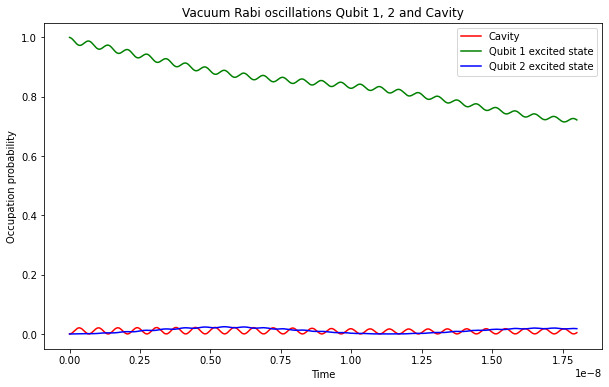

In [105]:
# get fit functions for both results
param1, param_cov1 = curve_fit(fit_guess, tlist, n_q1, maxfev=500000, p0=[amp1, r1*10**9, phase1, shift1, damp1], method='lm')
fit_func_q1 = param1[0]*np.exp(-param1[4]*tlist)*(np.sin(param1[1]*tlist + param1[2]))**2 + param1[3]

param2, param_cov2 = curve_fit(fit_guess, tlist, n_q2, maxfev=5000000, p0=[amp2, 2*np.pi*freq2, phase2, shift2,damp2])
fit_func_q2 = param2[0]*np.exp(-param2[4]*tlist)*(np.sin(param2[1]*tlist + param2[2]))**2 + param2[3]

print(f"Rabi Frequency from fitting qubit 1: {abs(2*param1[1])/GHz}GHz, period: {1/abs(2*param1[1])*GHz} ns")
print(f"Rabi Frequency from fitting qubit 2: {abs(2*param2[1])/GHz}GHz, period: {1/abs(2*param2[1])*GHz} ns")
print(f"Initial guesses ... amp1: {param1[0]}, damp1:{param1[4]}, freq1: {param1[1]}, phase1: {param1[2]}, shift1: {param1[3]}")

# Oscillations with both qubits
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(10,6))#figsize=(10,18))
axes.plot(tlist, n_c, 'r', label="Cavity")
axes.plot(tlist, n_q1, 'g', label="Qubit 1 excited state")
axes.plot(tlist, n_q2, 'b',  label="Qubit 2 excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations Qubit 1, 2 and Cavity')

# Oscillations with q1 and cavity
# axes[1].plot(tlist, n_c, 'r', label="Cavity")
# axes[1].plot(tlist, n_q1, 'g', label="Qubit 1 excited state")
# axes[1].plot(tlist, fit_func_q1, label="Qubit func. fit")
# axes[1].legend(loc=0)
# axes[1].set_xlabel('Time')
# axes[1].set_ylabel('Occupation probability')
# axes[1].set_title('Vacuum Rabi oscillations Qubit 1 and Cavity')

# Oscillations with q2 and cavity
# axes[2].plot(tlist, n_c, 'r', label="Cavity")
# axes[2].plot(tlist, n_q2, 'b',  label="Qubit 2 excited state")
# axes[2].plot(tlist, fit_func_q2, label="Qubit func. fit")
# axes[2].legend(loc=0)
# axes[2].set_xlabel('Time')
# axes[2].set_ylabel('Occupation probability')
# axes[2].set_title('Vacuum Rabi oscillations Qubit 2 and Cavity')